In [1]:
import pandas as pd
import numpy as np
import requests
import json
import time
import os 
import gzip
import timeit

from scripts.vectology_functions import create_aaa_distances, create_pair_distances, embed_text, encode_traits, create_efo_nxo


#!pip install pandas-profiling[notebook]==2.10.1
from pandas_profiling import ProfileReport

#from ontoma import OnToma
#otmap = OnToma()

import seaborn as sns

# Apply the default theme
sns.set_theme()

In [2]:
# globals
ebi_data = 'data/UK_Biobank_master_file.tsv'
#efo_nodes = 'data/efo-nodes.tsv'
#efo_data = 'data/efo_data.txt.gz'
efo_nodes = 'data/epigraphdb_efo_nodes.csv'
efo_rels = 'data/epigraphdb_efo_rels.csv'
nxontology_measure = 'batet'

modelData = [
    {'name':'BioSentVec','model':'BioSentVec'},
    {'name':'BioBERT','model':'biobert_v1.1_pubmed'},
    {'name':'BlueBERT','model':'NCBI_BERT_pubmed_mimic_uncased_L-12_H-768_A-12'},
    {'name':'GUSE','model':'GUSEv4'},
    {'name':'BERT-EFO','model':'BERT-EFO'},
    {'name':'Zooma','model':'Zooma'}
]

pallete="hls"
output='output/trait-efo'

In [3]:
# get the EBI UKB data
#get ebi data
#url='https://raw.githubusercontent.com/EBISPOT/EFO-UKB-mappings/master/UK_Biobank_master_file.tsv'
#ebi_df = pd.read_csv(url,sep='\t')

ebi_df = pd.read_csv(ebi_data,sep='\t')

#drop some columns
ebi_df = ebi_df[['ZOOMA QUERY','MAPPED_TERM_LABEL','MAPPED_TERM_URI','MAPPING_TYPE']]
ebi_df.rename(columns={'ZOOMA QUERY':'query'},inplace=True)
print(ebi_df.head())
print(ebi_df.shape)

#create new rows for multiple labels
#ebi_df = (
#        ebi_df.assign(label=ebi_df.MAPPED_TERM_LABEL.str.split("\|\|"))
#        .explode("label")
#        .reset_index(drop=True).drop('MAPPED_TERM_LABEL',axis=1)
#    )

#create new rows for multiple ids
ebi_df['MAPPED_TERM_URI']=ebi_df['MAPPED_TERM_URI'].str.replace('\|\|',',')
ebi_df['MAPPED_TERM_URI']=ebi_df['MAPPED_TERM_URI'].str.replace('\|',',')
ebi_df = (
        ebi_df.assign(id=ebi_df.MAPPED_TERM_URI.str.split(","))
        .explode("id")
        .reset_index(drop=True).drop('MAPPED_TERM_URI',axis=1)
    )

#clean up
ebi_df['id'] = ebi_df['id'].str.strip()

#remove underscores
ebi_df['query'] = ebi_df['query'].str.replace('_',' ')

#drop where query and id are duplicates
ebi_df.drop_duplicates(subset=['query','id'],inplace=True)
print(ebi_df.shape)

#drop nan
ebi_df.dropna(inplace=True)
print(ebi_df.shape)
print(ebi_df.head())

#drop cases where query and matched text are identical
print(ebi_df.shape)
ebi_df=ebi_df[ebi_df['query'].str.lower()!=ebi_df['MAPPED_TERM_LABEL'].str.lower()]
print(ebi_df.shape)

# add index as ID
ebi_df['mapping_id']=range(0,ebi_df.shape[0])
print(ebi_df.head())

# get counts of mapping type
print(ebi_df['MAPPING_TYPE'].value_counts())



                                      query       MAPPED_TERM_LABEL  \
0           Vascular disorders of intestine        vascular disease   
1                              Gonarthrosis  osteoarthritis || knee   
2  Psoriatic and enteropathic arthropathies     psoriatic arthritis   
3          Pain associated with micturition                 dysuria   
4                                Other mood           mood disorder   

            MAPPED_TERM_URI MAPPING_TYPE  
0  EFO_0004264, EFO_0009431        Broad  
1               EFO_0004616        Broad  
2               EFO_0003778      ? Broad  
3               EFO_0003901      ? Broad  
4               EFO_0004247      ? Broad  
(1565, 4)
(1612, 4)
(1598, 4)
                                      query       MAPPED_TERM_LABEL  \
0           Vascular disorders of intestine        vascular disease   
1           Vascular disorders of intestine        vascular disease   
2                              Gonarthrosis  osteoarthritis || knee   
3

In [5]:
%%time

# get EFO node data
efo_node_df = pd.read_csv(efo_nodes)
efo_node_df.rename(columns={'efo.value':'efo_label','efo.id':'efo_id'},inplace=True)
#drop type
efo_node_df.drop('efo.type',inplace=True,axis=1)
efo_node_df.drop_duplicates(inplace=True)
print(efo_node_df)

                                      efo_label  \
0                 Xeroderma pigmentosum variant   
1                         Xeroderma pigmentosum   
2                               Ischemic stroke   
3                             Cerebral ischemia   
4                          small cell carcinoma   
...                                         ...   
25385         Acetazolamide-responsive myotonia   
25386  Complete androgen insensitivity syndrome   
25387                Intermediate DEND syndrome   
25388                              Epiblepharon   
25389              Congenital eyelid retraction   

                                          efo_id  
0       http://www.orpha.net/ORDO/Orphanet_90342  
1         http://www.orpha.net/ORDO/Orphanet_910  
2      http://purl.obolibrary.org/obo/HP_0002140  
3      http://purl.obolibrary.org/obo/HP_0002637  
4           http://www.ebi.ac.uk/efo/EFO_0008524  
...                                          ...  
25385   http://www.orpha.net/O

In [6]:
%%time

#check all terms in EBI data set are in EFO node data
efo_node_ids = list(efo_node_df['efo_id'])
ebi_ids = list(ebi_df['id'])
missing=[]
matched = []
for i in ebi_ids:
    match = False
    for s in efo_node_ids:
        if i in s and match == False:
            matched.append(s)
            match = True
    if match == False:
        missing.append(i)
print('Missing:',len(missing))

# remove missing from ukb data
print(ebi_df.shape)
for i in missing:
    ebi_df = ebi_df.drop(ebi_df[ebi_df['id'].str.contains(i)].index)
ebi_df['full_id'] = matched
print(ebi_df.head())
print(ebi_df.shape)
ebi_df.to_csv('output/ebi-ukb-cleaned.tsv',index=False,sep='\t')


Missing: 19
(1320, 5)
                                      query       MAPPED_TERM_LABEL  \
0           Vascular disorders of intestine        vascular disease   
1           Vascular disorders of intestine        vascular disease   
2                              Gonarthrosis  osteoarthritis || knee   
3  Psoriatic and enteropathic arthropathies     psoriatic arthritis   
4          Pain associated with micturition                 dysuria   

  MAPPING_TYPE           id  mapping_id                               full_id  
0        Broad  EFO_0004264           0  http://www.ebi.ac.uk/efo/EFO_0004264  
1        Broad  EFO_0009431           1  http://www.ebi.ac.uk/efo/EFO_0009431  
2        Broad  EFO_0004616           2  http://www.ebi.ac.uk/efo/EFO_0004616  
3      ? Broad  EFO_0003778           3  http://www.ebi.ac.uk/efo/EFO_0003778  
4      ? Broad  EFO_0003901           4  http://www.ebi.ac.uk/efo/EFO_0003901  
(1301, 6)
CPU times: user 3.63 s, sys: 19.5 ms, total: 3.65 s
Wall time

In [ ]:
%%time

# encode the EBI query terms with Vectology models
queries = list(ebi_df['query'])
chunk=10

vectology_models = ['BioSentVec','BioBERT','BlueBERT']

for m in modelData:
    name = m['name']
    model = m['model']
    if name in vectology_models: 
        f = f"output/{m['name']}-ebi-encode.npy"
        if os.path.exists(f):
            print(name,'done')
        else:
            print('Encoding EBI queriues with',model)
            results=[]
            for i in range(0,len(queries),chunk):
                if i % 100 == 0:
                    print(i)
                batch = queries[i:i+chunk]
                #print('\n',i,queries[i:i+chunk])
                res = embed_text(textList=batch,model=model)
                for r in res:
                    results.append(r)
            print('Results',len(results))
            np.save(f,results)


In [ ]:
%%time

# encode the EFO query terms with Vectology models
queries = list(efo_node_df['efo_label'])
chunk=20

vectology_models = ['BioSentVec','BioBERT','BlueBERT']

for m in modelData:
    name = m['name']
    model = m['model']
    if name in vectology_models: 
        f = f"output/{m['name']}-efo-encode.npy"
        if os.path.exists(f):
            print(name,'done')
        else:
            print('Encoding EFO queriues with',model)
            results=[]
            for i in range(0,len(queries),chunk):
                if i % 100 == 0:
                    print(i)
                batch = queries[i:i+chunk]
                #print('\n',i,queries[i:i+chunk])
                res = embed_text(textList=batch,model=model)
                for r in res:
                    results.append(r)
            print('Results',len(results))
            np.save(f,results)

In [ ]:
%%time

# Google Universal Sentence Encoder

#!pip install  "tensorflow>=2.0.0"
#!pip install  --upgrade tensorflow-hub

import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
%%time

# create GUSE encodings for EBI and EFO

guse_ebi_embeddings = embed(ebi_df['query'])
guse_efo_embeddings = embed(efo_node_df['efo_label'])

guse_ebi_embeddings_list = []
for g in guse_ebi_embeddings:
    guse_ebi_embeddings_list.append(g.numpy())
np.save(f'output/GUSE-ebi-encode.npy',guse_ebi_embeddings_list)
#ebi_df['GUSE']=guse_ebi_embeddings_list

guse_efo_embeddings_list = []
for g in guse_efo_embeddings:
    guse_efo_embeddings_list.append(g.numpy())
np.save('output/GUSE-efo-encode.npy',guse_efo_embeddings_list)
#efo_df['GUSE']=guse_efo_embeddings_list

In [ ]:
%%time

#create nxontology network of EFO relationships
efo_rel_df=pd.read_csv(efo_rels)
efo_nx = create_efo_nxo(df=efo_rel_df,child_col='efo.id',parent_col='parent_efo.id')
efo_nx.freeze()

In [ ]:
def run_pairs(model):
    dd_name = f"{output}/{model}-dd.npy"
    
    #v1 = list(ebi_df[model])
    #v2 = list(efo_df[model])
    if os.path.exists(f'output/{model}-ebi-encode.npy'):
        v1 = np.load(f'output/{model}-ebi-encode.npy')
        v2 = np.load(f'output/{model}-efo-encode.npy')
        
        if os.path.exists(dd_name):
            print(dd_name,'already created, loading...')
            with open(dd_name, 'rb') as f:
                dd = np.load(f)
        else:    
            # cosine of lists
            dd = create_pair_distances(v1,v2)
            np.save(dd_name,dd)
        print('done')
        return dd

def write_to_file(model_name,pairwise_data):
    print('writing',model_name)
    f = f'{output}/{model_name}-pairwise.tsv.gz'
    if os.path.exists(f):
        print('Already done',f)
    else:
        fo = gzip.open(f,'w')
        fo.write("mapping_id\tmanual\tprediction\tscore\n".encode('utf-8'))
        ebi_efo_list = list(ebi_df['full_id'])
        efo_list = list(efo_node_df['efo_id'])
        for i in range(0,len(ebi_efo_list)):
            if i % 100 == 0:
                print(i)
            # write to file
            mCount=0
            for j in range(i,len(efo_list)):
                if i != j:
                    #print(ids[i],ids[j],1-pws[mCount])
                    score = 1-pairwise_data[i][j]
                    fo.write(f"{i}\t{ebi_efo_list[i]}\t{efo_list[j]}\t{score}\n".encode('utf-8'))
                    mCount+=1

In [ ]:
%%time

#dd = run_pairs('BioSentVec')
#get_top('BioSentVec',dd)

#get_top('BioSentVec',dd)

for m in modelData:
    print(m['name'])
    dd = run_pairs(m['name'])
    if dd is not None:
        #get_top(m['name'],dd)   
        write_to_file(model_name=m['name'],pairwise_data=dd) 
    else:
        print(m['name'],'not done')

In [ ]:
# zooma using API
def run_zooma(text):
    zooma_api = 'https://www.ebi.ac.uk/spot/zooma/v2/api/services/annotate'
    payload = {
        'propertyValue':text,
        'filter':'required:[none],ontologies:[efo]'
    }
    res = requests.get(zooma_api,params=payload).json()
    if res:
        #print(res[0]['confidence'])
        #print(text,res[0]['semanticTags'])
        efo = res[0]['semanticTags'][0]
        confidence = res[0]['confidence']
        return {'query':text,'prediction':efo.strip(),'confidence':confidence.strip()}
    else:
        return {'query':text,'prediction':'NA','confidence':'NA'}

In [ ]:
%%time

# takes around 3 minutes for 1,000
f=f'{output}/zooma.tsv'
if os.path.exists(f):
    print('Zooma done')
else:
    all_res = []
    count=0
    for q in list(ebi_df['query']):
        res = run_zooma(q)
        res['mapping_id']=count
        all_res.append(res)
        print(res)
        count+=1
    #print(list(res))
    df = pd.DataFrame(all_res)
    #df['manual'] = ebi_df['full_id'][0:5] 
    #df['mapping_id'] = ebi_df['mapping_id'][0:5]
    print(df.head())
    #df = pd.merge(df,ebi_df,left_on='query',right_on='query')
    print(df.shape)
    #df[['mapping_id','manual','prediction','confidence']].to_csv(f,index=False,sep='\t')
    df.to_csv(f,index=False,sep='\t')

In [ ]:
#print(zooma_df.head())

# merge with ebi file
#m = pd.merge(zooma_df,ebi_df,left_on='PROPERTY VALUE',right_on='query')
#m.drop_duplicates(inplace=True)
#print(m.head())
#print(m.shape)

dis_results=[]
efo_results=[]
df = pd.read_csv(f'{output}/zooma.tsv',sep='\t')
# add manual EFO
df = pd.merge(df,ebi_df[['mapping_id','full_id']],left_on='mapping_id',right_on='mapping_id')
df.rename(columns={'full_id':'manual'},inplace=True)
print(df.head())
for i, row in df.iterrows():
    try:
        res = similarity = efo_nx.similarity(row['prediction'],row['manual']).results()
        dis_results.append(res[nxontology_measure])
    except:
        dis_results.append(0)
        
print(len(dis_results))
df['score'] = dis_results
print(df[df['score']>0.9].shape)
df.to_csv(f'{output}/Zooma-pairwise-filter.tsv.gz',sep='\t',index=False,compression='gzip')
sns.displot(df, x="score",kde=True)

In [ ]:
%%time

top_x = 100

def filter_paiwise_file(model_name):
    print('filter_pairwise_file',model_name)
    f = f"{output}/{model_name}-pairwise-filter.tsv.gz"
    if os.path.exists(f):
        print('Already done',model_name)
        return
    else:
        try:
            df = pd.read_csv(f"{output}/{model_name}-pairwise.tsv.gz",sep='\t')
            print(df.shape)
            df = df.sort_values(by=['score'],ascending=False).groupby('mapping_id').head(top_x)
            # drop duplicates
            df.drop_duplicates(subset=['mapping_id','manual','prediction'],inplace=True)
            print(df.shape)
            df.sort_values(by=['mapping_id','score'],ascending=[True,False]).to_csv(f,sep='\t',index=False,compression='gzip')
        except:
            print('Error',model_name)
            return

def filter_bert():
    df = pd.read_csv(f"data/efo_mk1_inference_top100_no_underscores.csv.gz")
    df_top = df.sort_values(by=['score']).groupby('text_1').head(top_x)
    df_top = pd.merge(df_top,ebi_df[['mapping_id','query','full_id']],left_on='text_1',right_on='query')
    df_top.rename(columns={'full_id':'manual'},inplace=True)
    df_top.drop('query',axis=1,inplace=True)

    #map to predicted EFO
    df_top = pd.merge(df_top,efo_node_df,left_on='text_2',right_on='efo_label')
    df_top.rename(columns={'efo_id':'prediction'},inplace=True)
    df_top.drop('efo_label',axis=1,inplace=True)
    df_top.drop_duplicates(subset=['mapping_id','manual','prediction'],inplace=True)
    print(df_top.head())
    df_top[['mapping_id','manual','prediction','score']].sort_values(by=['mapping_id','score']).to_csv(f'{output}/BERT-EFO-pairwise-filter.tsv.gz',index=False,compression='gzip',sep='\t')
    print(df_top.head())

def get_top_using_pairwise_file(model_name,top_num):
    f = f"{output}/{model_name}-top-{top_num}.tsv"
    if os.path.exists(f):
        print('Top done',model_name)
    else:
        print('Reading',model_name)
        try:
            df = pd.read_csv(f"{output}/{model_name}-pairwise-filter.tsv.gz",sep='\t')
        except:
            print('Data do not exist for',model_name)
            return
        print(df.head())
        print(df.shape)
        #remove duplicates
        df.drop_duplicates(subset=['manual','prediction'],inplace=True)
        top_res = []
        manual_efos = list(ebi_df['full_id'])
        for i in range(0,len(manual_efos)):
        #for i in range(0,10):
            manual_efo = manual_efos[i]
           # print(i,manual_efo)
            efo_predictions = df[df['manual']==manual_efo].head(n=top_num)[['prediction','score']]
            #end = time.time()
            #print(end-start)
            #print(efo_predictions)
            # run nxontolog for each
            for j,row in efo_predictions.iterrows():
                predicted_efo = row['prediction']
                score = row['score']
                #print(predicted_efo,score)
                try:
                    res = efo_nx.similarity(manual_efo,predicted_efo).results()
                    nx_val = res[nxontology_measure]
                except:
                    nx_val = 0
                top_res.append({'mapping_id':i,'manual':manual_efo,'prediction':predicted_efo,'score':score,'nx':nx_val})  
                #print(f"manual: {manual_efo} predicted: {predicted_efo} score: {score} nx: {nx_val}")
        res_df = pd.DataFrame(top_res)
        res_df.to_csv(f,index=False,sep='\t')

filter_bert()
for m in modelData:
    filter_paiwise_file(model_name=m['name'])
    get_top_using_pairwise_file(model_name=m['name'],top_num=100)



In [ ]:
# calculate weighted average

def calc_weighted_average(model_name,top_num,mapping_types):
    f = f"{output}/{model_name}-top-100.tsv"
    print(f)
    res = []
    try:
        df = pd.read_csv(f,sep='\t')
        #print(df.head())
    except:
        print('Data do not exist for',model_name)
        return
    manual_efos = list(ebi_df['full_id'])
    for i in range(0,len(manual_efos)):
        manual_efo = manual_efos[i]
        #filter on type
        mapping_type = ebi_df[ebi_df['full_id']==manual_efo]['MAPPING_TYPE'].values[0]
        #print(mapping_type)
        if mapping_type in mapping_types:
            #print(i,manual_efo)
            nx_scores = list(df[df['manual']==manual_efo].head(n=top_num)['nx'])
            weights = list(reversed(range(1,(len(nx_scores)+1))))
            #print(model_name,manual_efo,nx_scores,weights)
            try:
                weighted_avg = round(np.average( nx_scores, weights = weights),3)
            except:
                weighted_avg = 0
            res.append(weighted_avg)
            #print(nx_scores,weights,weighted_avg)
    print(len(res))
    return res

#res = calc_weighted_average('BioSentVec',5)


top_nums=[1,2,5,10,20,50,100]
#top_nums=[2]

def run(mapping_types,mapping_name):
    for top_num in top_nums:
        all_res = {}
        for m in modelData:
            if top_num > 1 and m['name'] == 'Zooma':
                print('No data for Zooma')
                continue
            else:
                res = calc_weighted_average(m['name'],top_num,mapping_types)
                if res is not None:
                    all_res[m['name']]=res

        df = pd.DataFrame(all_res)
        df['efo'] = ebi_df['full_id']
        #print(df.head())
        df_melt = pd.melt(df, id_vars=['efo'])
        df_melt.rename(columns={'variable':'Model'},inplace=True)
        #print(df_melt.head())
        #ax = sns.displot(x="value", hue="Model", data=df_melt, kind='kde', cut=0, palette=pallete, height=6, cumulative=True,common_norm=False)
        ax = sns.displot(x="value", hue="Model", data=df_melt, kind='kde', cut=0, palette=pallete, height=6,common_norm=True)
        #sns_plot = sns.displot(ebi_df, x=f"{model}-nx",kde=True)
        ax.set(xlabel=f'Weighted average of nx', ylabel='kde')
        #ax.set_xscale("log")
        ax.savefig(f"{output}/pdfs/weighted-average-nx-{top_num}-{mapping_name}.pdf")

run(mapping_types=['Exact','Broad','Narrow'],mapping_name='all')
run(mapping_types=['Exact'],mapping_name='exact')
run(mapping_types=['Broad','Narrow'],mapping_name='broad-narrow')


output/trait-efo/BioSentVec-top-100.tsv
output/trait-efo/BioBERT-top-100.tsv
output/trait-efo/BlueBERT-top-100.tsv
output/trait-efo/GUSE-top-100.tsv
output/trait-efo/BERT-EFO-top-100.tsv
output/trait-efo/Zooma-top-100.tsv
[{'Exact': 299, 'Broad': 173, 'Narrow': 7, 'Model': 'BioSentVec', 'Total': 479}, {'Exact': 248, 'Broad': 125, 'Narrow': 3, 'Model': 'BioBERT', 'Total': 376}, {'Exact': 251, 'Broad': 120, 'Narrow': 9, 'Model': 'BlueBERT', 'Total': 380}, {'Exact': 229, 'Broad': 119, 'Narrow': 6, 'Model': 'GUSE', 'Total': 354}, {'Exact': 299, 'Broad': 187, 'Narrow': 9, 'Model': 'BERT-EFO', 'Total': 495}, {'Exact': 220, 'Broad': 78, 'Narrow': 12, 'Model': 'Zooma', 'Total': 310}]
   Exact  Broad  Narrow       Model  Total
4    299    187       9    BERT-EFO    495
0    299    173       7  BioSentVec    479
2    251    120       9    BlueBERT    380
1    248    125       3     BioBERT    376
3    229    119       6        GUSE    354
5    220     78      12       Zooma    310


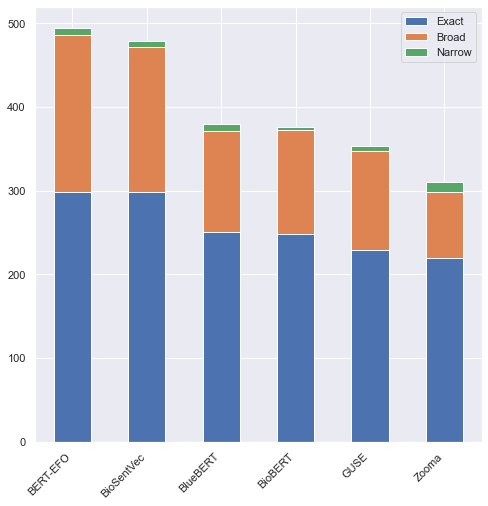

In [8]:
# get some top counts
# to do
# - statify by mapping_type

ebi_df_exact = ebi_df[ebi_df['MAPPING_TYPE']=='Exact']

res = []
for i in modelData:
    fName = f"{output}/{i['name']}-top-100.tsv"
    print(fName)
    df = pd.read_csv(fName,sep='\t')

    df = pd.merge(df,ebi_df[['mapping_id','MAPPING_TYPE']],left_on='mapping_id',right_on='mapping_id')
    df.drop_duplicates(subset=['mapping_id','manual'],inplace=True)   
 
    # filter by mapping_type
    df = df[df['MAPPING_TYPE'].isin(['Exact','Broad','Narrow'])]
    d = dict(df[df['nx']==1]['MAPPING_TYPE'].value_counts())
    d['Model'] = i['name']
    d['Total'] = df[df['nx']==1].shape[0]
    res.append(d)

print(res)
res_df = pd.DataFrame(res).sort_values(by='Total',ascending=False)
print(res_df)
ax = res_df[['Exact','Broad','Narrow','Model']].plot.bar(stacked=True,figsize=(8,8))
ax.set_xticklabels(res_df['Model'], rotation=45, ha='right')
fig = ax.get_figure()
fig.savefig(f'{output}/pdfs/top-counts-by-type.png',dpi=1000)

In [10]:
# find cases where no model mapped correctly >0.5 nx
match = []
ebi_df_exact = ebi_df[ebi_df['MAPPING_TYPE']=='Exact']

for i in modelData:
    fName = f"{output}/{i['name']}-top-100.tsv"
    print(fName)
    df = pd.read_csv(fName,sep='\t')
    # maybe filter on exact mapping type
    #df = df[df['mapping_id'].isin(exact_mapping_type)]
    df.drop_duplicates(subset=['mapping_id','manual'],inplace=True) 
    #print(df.head())
    match.extend(list(set(list(df[df['nx']>0.5]['mapping_id']))))
    
missing_df = ebi_df_exact[~ebi_df_exact['mapping_id'].isin(match)]
print(missing_df.shape)
print(missing_df['MAPPING_TYPE'].value_counts())
#print(missing_df[missing_df['MAPPING_TYPE']=='Exact'].head())

# add the top prediction from each model to the missing df
# note, some of them don't have any matches to top 100 - why is that...???
for i in modelData:
    fName = f"{output}/{i['name']}-top-100.tsv"
    print(fName)
    df = pd.read_csv(fName,sep='\t')
    df.drop_duplicates(subset=['mapping_id','manual'],inplace=True) 
    # get data
    missing_df = pd.merge(df[['mapping_id','prediction','score','nx']],missing_df,left_on='mapping_id',right_on='mapping_id')
    missing_df.rename(columns={'prediction':f"{i['name']}-efo",'score':f"{i['name']}-score",'nx':f"{i['name']}-nx"},inplace=True)
print(missing_df.head())
missing_df.to_csv(f'{output}/no-predictions.tsv',sep='\t',index=False)

output/trait-efo/BioSentVec-top-100.tsv
output/trait-efo/BioBERT-top-100.tsv
output/trait-efo/BlueBERT-top-100.tsv
output/trait-efo/GUSE-top-100.tsv
output/trait-efo/BERT-EFO-top-100.tsv
output/trait-efo/Zooma-top-100.tsv
(58, 6)
Exact    58
Name: MAPPING_TYPE, dtype: int64
output/trait-efo/BioSentVec-top-100.tsv
output/trait-efo/BioBERT-top-100.tsv
output/trait-efo/BlueBERT-top-100.tsv
output/trait-efo/GUSE-top-100.tsv
output/trait-efo/BERT-EFO-top-100.tsv
output/trait-efo/Zooma-top-100.tsv
   mapping_id                                     Zooma-efo  Zooma-score  \
0         118          http://www.ebi.ac.uk/efo/EFO_0009265     0.083333   
1         119          http://www.ebi.ac.uk/efo/EFO_1000797     0.333333   
2         139  http://purl.obolibrary.org/obo/MONDO_0008666     0.416667   
3         229          http://www.ebi.ac.uk/efo/EFO_0003763     0.312500   
4         234     http://purl.obolibrary.org/obo/HP_0000975     0.153846   

   Zooma-nx                               BERT

In [ ]:
ebi_df['MAPPING_TYPE'].value_counts()